**STATISTICAL ARBITRAGE: PAIR-TRADING STRATEGY**

**DUKE COMPUTER SCIENCE 216**

**FINAL PROJECT**




---




**INTRODUCTION**

Our project is based on the concept of pairs trading, a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement. This method is especially intriguing in today’s market—the extreme volatility of which we saw recently with the GameStop short squeeze. Trading and generating profits in an increasingly saturated market is difficult, so we want to use data science and algorithmic techniques to see if we can generate profits without exposure to market risks. Our goal is thus to algorithmically implement a pairs trading strategy and test if it is profitable. 

Thus, our research question is as follows: For a given amount of risk, seeing as today’s market is extremely volatile, what is the maximum amount of returns we can generate using a pairs trading strategy?


---

**BACKGROUND**

In finance, statistical arbitrage refers to a group of trading strategies that utilize mean reversion analyses to invest in diverse portfolios of up to thousands of securities for a very short period of time, often only a few seconds but up to multiple days. Statistical arbitrage is a deeply quantitative, analytical approach to trading that aims to reduce exposure to beta as much as possible. Investors typically identify arbitrage situations through mathematical modeling techniques.

Pairs trading, one statistical arbitrage strategy, uses pairs of securities that have some sort of underlying economic link. An example could be two companies that manufacture the same type of product, Like Microsoft and Apple. Because of this underlying link, we would expect the spread (ratio or difference in prices) between these two to remain constant with time. However, on occasion there might be a divergence in the spread between these two pairs caused by temporary supply/demand changes, large buy/sell orders for one security, reaction for important news about one of the companies, etc. When there is a temporary divergence between the two securities, i.e. one stock moves up while the other moves down, the pairs trade would be to short the outperforming stock and to long the underperforming one, betting that the "spread" between the two would eventually converge. The idea is that in the long run, the price ratio between two stocks fluctuates less than stocks themselves. So when the price of a particular stock deviates too much from the calculated mean, there is an opportunity for profits as the price will eventually go back to the mean ratio.

We will be applying our algorithmic pairs trading strategy to securities in the US tech sector. There has been substantial literature explaining the profitability of a pairs trading approach to investment such as the self-financing pairs portfolio trading strategy presented by Gatev et al. in 2006. Gatev et al. tested pairs trading with daily data over 1962-2002. They matched stocks into pairs with minimum distance between normalized historical prices. They found that a simple trading rule yields average annualized excess returns of up to 11 percent for selffinancing portfolios of pairs. The profits typically exceeded conservative transaction costs estimates. Furthermore, bootstrap results suggested that the pairs effect differs from previously-documented reversal profits.

---

**OUR APPROACH**

# Data exploration & selecting pairs
In order to develop a trading signal, we first collected and cleaned the data to ensure it was reliable.

 first step to developing a trading signal is to collect and clean reliable data.

First, we import all libraries necessary for the implementation of our strategy.


In [ ]:
# import libraries
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm
import scipy
from google.colab import files
  
  
uploaded = files.upload()


We then import the csv file containing information of all stocks from the tech industry

In [ ]:
# import csv file containing information of all stocks from tech industry

tech_industry = pd.read_csv('tech-industry.csv')

Display first 5 elements of the dataset

In [ ]:
# display first 5 elements
tech_industry.head()

In [ ]:
# sort tech stocks by trading volume
tech_industry = tech_industry.sort_values(by='Volume', ascending=False)

# top 10 tech stocks with most trading value
tech_industry = tech_industry[:10]

# display the dataframe
display(tech_industry)

In [ ]:
# get stock tickers of these 10 stocks as tickers list
tickers = tech_industry.Symbol.values.tolist()

# display list of tickers
display(tickers)

['AAPL', 'AMD', 'MSFT', 'INTC', 'MU', 'CSCO', 'AMAT', 'ORCL', 'PYPL', 'HPE']

In [ ]:
######################################################################################################################
######################################################################################################################
# NOTE: DO NOT RUN THESE BLOCKS OF CODE IF YOU ARE WORKING ON THIS SAME NOTEBOOK
######################################################################################################################
######################################################################################################################
######################################################################################################################

# fetch stock price data for each of the tickers from yahoo finance
# for the period 2016 to 2020 and save as separate csv files

# for ticker in tickers:
#     df =  pdr.get_data_yahoo(symbols=ticker, start = datetime(2016, 1, 1), end = datetime(2020, 1, 1))
#     df.to_csv(ticker+'.csv') 

In [ ]:
# read apple stock price csv to verify if data has been collected correctly
# aapl = pd.read_csv('AAPL.csv')

In [ ]:
# display first 5 
# aapl.head()

In [ ]:
# display last 5 rows
# aapl.tail()

In [ ]:
# Success! Data has been fetched correctly. Now we will clean the data as per our requirements
# We only need Date and Adj Close column values for each of the stocks
# We choose Adj Close over just the close price because the Adj Close 
# is normalized prices according to the individual stock's historical dividends, splits, etc.
# and hence, better quality price data than just the close price

In [ ]:
######################################################################################################################
######################################################################################################################
######################################################################################################################
# RUN FROM THIS POINT FORWARD IF WORKING ON NOTEBOOK
######################################################################################################################
######################################################################################################################
######################################################################################################################

In [ ]:
# create new price dataframe
price = pd.DataFrame()

In [ ]:
# for each of the ticker, add the corresponding adjusted close price to the combined price dataframe
for ticker in tickers:
    df = pd.read_csv(ticker+'.csv')
    price['date'] = df['Date']
    price[ticker+'_close'] = df['Adj Close']
    

In [ ]:
# display combined price data frame first 5 values
display(price.head())

,date,AAPL_close,AMD_close,MSFT_close,INTC_close,MU_close,CSCO_close,AMAT_close,ORCL_close,PYPL_close,HPE_close
0,2015-12-31,24.343718,2.87,50.510929,29.935064,14.16,22.774519,17.321833,33.539711,36.200001,7.771190
1,2016-01-04,24.364536,2.77,49.891834,29.535355,14.33,22.318188,17.136276,32.958900,34.750000,7.735402
2,2016-01-05,23.753977,2.75,50.119446,29.396330,14.82,22.216778,17.154827,32.857491,34.310001,7.684277
3,2016-01-06,23.289116,2.51,49.209011,28.744617,14.22,21.980158,16.449711,33.023438,33.980000,7.566686
4,2016-01-07,22.306208,2.28,47.497398,27.667130,13.66,21.473118,15.967264,32.304333,33.130001,7.009409


In [ ]:
# check if any values are missing
price.isnull().values.any()

False

In [ ]:
# Awesome! We have succesfully combined the required data

In [ ]:
# set date column as index
price = price.set_index('date')

In [ ]:
price.shape

(1007, 10)

In [ ]:
# Now we will split our dataset into train and test data
# we will use 2 years data as training and 2 years data as testing
# roughly splitting the dataset into 2 parts

In [ ]:
train_data = price[:507]
train_data.shape

(507, 10)

In [ ]:
# train data starting from 2015-12-31 to 2018-01-04 (507 values)

In [ ]:
test_data = price[507:]
test_data.shape

(500, 10)

In [ ]:
# test data starting from 2018-01-05 to 2019-12-31 (500 values)

In [ ]:
# from this point on we will be working only with our training data intil we get to the testing phase

# Testing correlation

Text(0.5, 1.0, 'autocorrelation matrix')

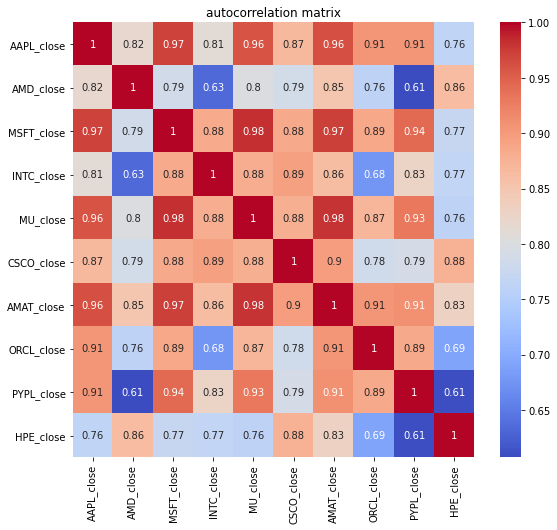

In [ ]:
# plot correlation matrix of all pairs of stocks using training data
# using pearson method : standard correlation coefficient
fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(train_data.corr(method='pearson'), ax=ax, cmap='coolwarm', annot=True) 
ax.set_title('autocorrelation matrix')

In [ ]:
# ranking all unique stock pairs based on correlation computed above (descending order) 
pair_ranks = train_data.corr(method='pearson').stack().sort_values(ascending=False).reset_index()
pair_ranks = pair_ranks[pair_ranks.level_0 < pair_ranks.level_1].reset_index().drop(columns='index')
pair_ranks = pair_ranks.rename(columns={'level_0': 'stock1', 'level_1': 'stock2'})

In [ ]:
# display top 5 correlated pairs
pair_ranks.head()

,stock1,stock2,0
0,MSFT_close,MU_close,0.981962
1,AMAT_close,MU_close,0.980960
2,AMAT_close,MSFT_close,0.972609
3,AAPL_close,MSFT_close,0.971415
4,AAPL_close,AMAT_close,0.961919


# Cointegration


In [ ]:
# Now we will test for cointegration

In [ ]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [ ]:
# find best pairs based on cointegration
pvalues, pairs = find_cointegrated_pairs(train_data)

Eleane:




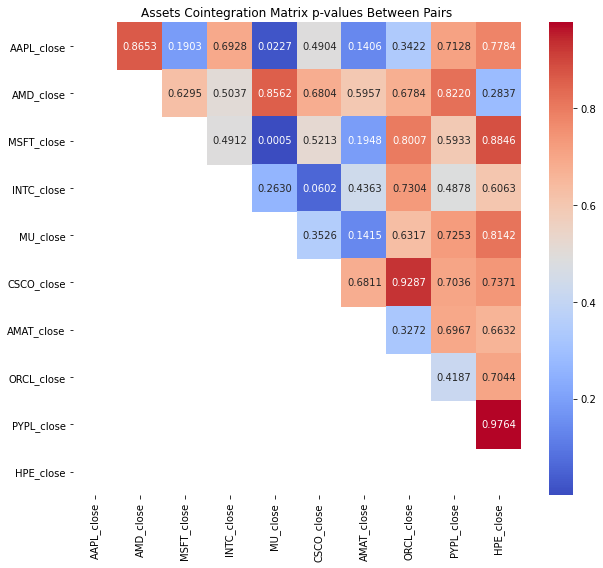

In [ ]:
# plot the heatmap
fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(pvalues, xticklabels = train_data.columns, yticklabels = train_data.columns, 
            cmap = 'coolwarm', annot = True, fmt=".4f", mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()

In [ ]:
# display the pairs
display(pairs)

[('AAPL_close', 'MU_close'), ('MSFT_close', 'MU_close')]

# Training on selected stock pair
We notice that MSFT and MU pair is highly ranked on the basis of both correlation and cointegration tests. Based on the statistical significance (low p-value of 0.0005) we will choose the MSFT and MU pair to develop our strategy moving forward.


In [ ]:
# chosen pair
stock1 = 'MSFT_close'
stock2 = 'MU_close'

In [ ]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['stock1'] = train_data[stock1]
train['stock2'] = train_data[stock2]

Below, we explore our selected data, displaying and visualizing a few rows of closing prices of both stocks.

In [ ]:
# display first 5 rows
train.head()

,stock1,stock2
date,,
2015-12-31,50.510929,14.16
2016-01-04,49.891834,14.33
2016-01-05,50.119446,14.82
2016-01-06,49.209011,14.22
2016-01-07,47.497398,13.66


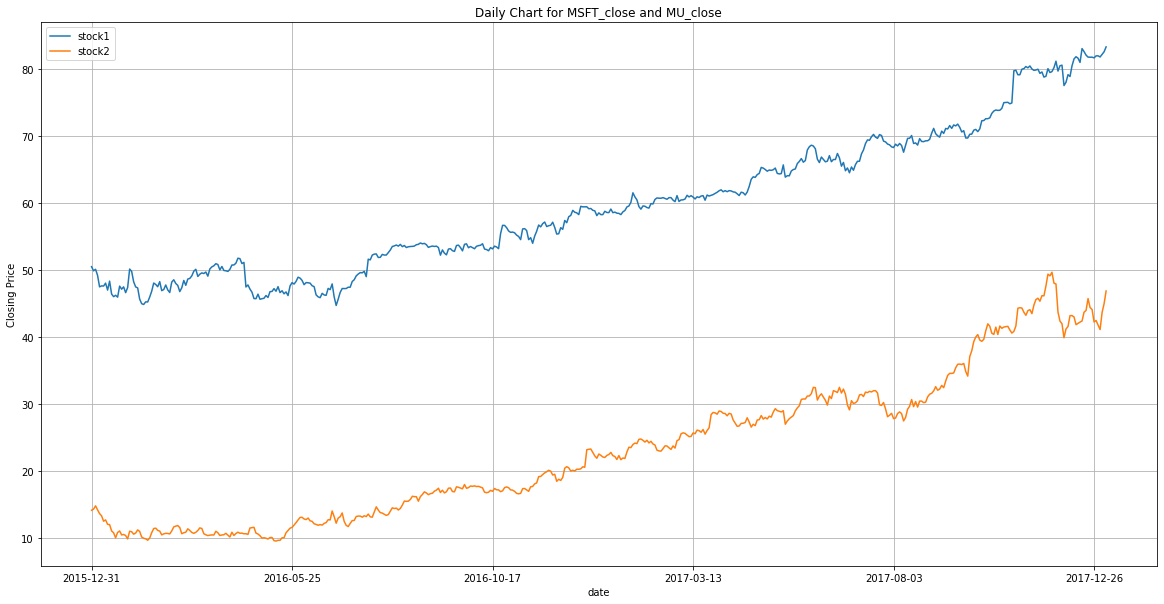

In [ ]:
# visualize closing prices of both stocks from training data
ax = train[['stock1','stock2']].plot(figsize=(20, 10), title = 'Daily Chart for {} and {}'.format(stock1,stock2))
ax.set_ylabel("Closing Price")
ax.grid(True)

Further tests are conducted to validate the pair of stocks chosen.
Since we have chosen stocks MSFT and MU which are cointegrated, we know that the mean and variance of the spread equation remains constant over time.

We then want to test the hypothesis that the expected value of the spread will remain 0, and see when there are statistical "abnormalities" that indicate pairs trading can be used.

For any pair of
stocks, we define spread as

```
Spread = log(a) – nlog(b)
```
where a and b are the stock prices of stock A and B.
These further tests on the spread and mean help us see if prices deviate from an expected stationary value of 0. 



---



In order to calculate n, the hedge radio, we first regress the stock prices.

Doing so allows us to see the residuals which tell us how much the actual value of ‘spread’ deviates from 0 for the calculated ‘n’. These residuals are studied so that we understand whether or not they form a trend. If they do not form a trend, that means the spread moves around 0 randomly and is stationary.

In [ ]:
X = train['stock1']
X = sm.add_constant(X)
Y = train['stock2']

# run OLS regression
model = sm.OLS(Y, X)
results = model.fit()

# print regression summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 stock2   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 1.362e+04
Date:                Sun, 11 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:58:31   Log-Likelihood:                -1077.3
No. Observations:                 507   AIC:                             2159.
Df Residuals:                     505   BIC:                             2167.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.1831      0.526    -70.757      0.0

Then, in order to calculate the hedge ratio, we conduct the [Augmented Dickey Fuller](https://blog.quantinsti.com/augmented-dickey-fuller-adf-test-for-a-pairs-trading-strategy/) (ADF) test. ADF is a hypothesis test which gives a p-value as the result. If this value is less than 0.05 or 0.01, we can say with 95% or 99% confidence that the signal is stationary and we can choose this pair.

In [ ]:
# beta or hedge ratio
slope = results.params[1] # beta
print("Hedge ratio is", slope)
# conduct Augmented Dickey-Fuller test
#adf = adfuller (res)  # ADF Test -- Augmented Dickey-Fuller test for unit root
#print('Critical Value = ', adf[0])

Hedge ratio is 1.0120242547064042


We then visualize the spread, using our calculated value of n and training stock prices.



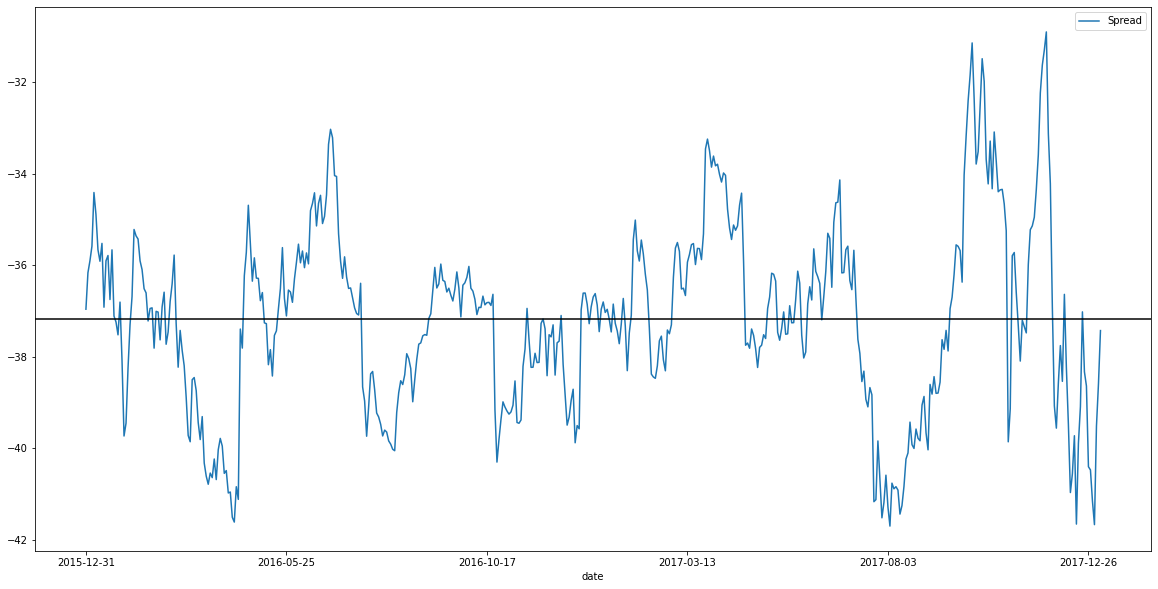

In [ ]:
# calculating the spread
spread = train['stock2'] - slope * train['stock1']

spread.plot(figsize=(20,10))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

Continuing, we look at the price ratio of the stock pair to see if the ratio moves around a stable mean.

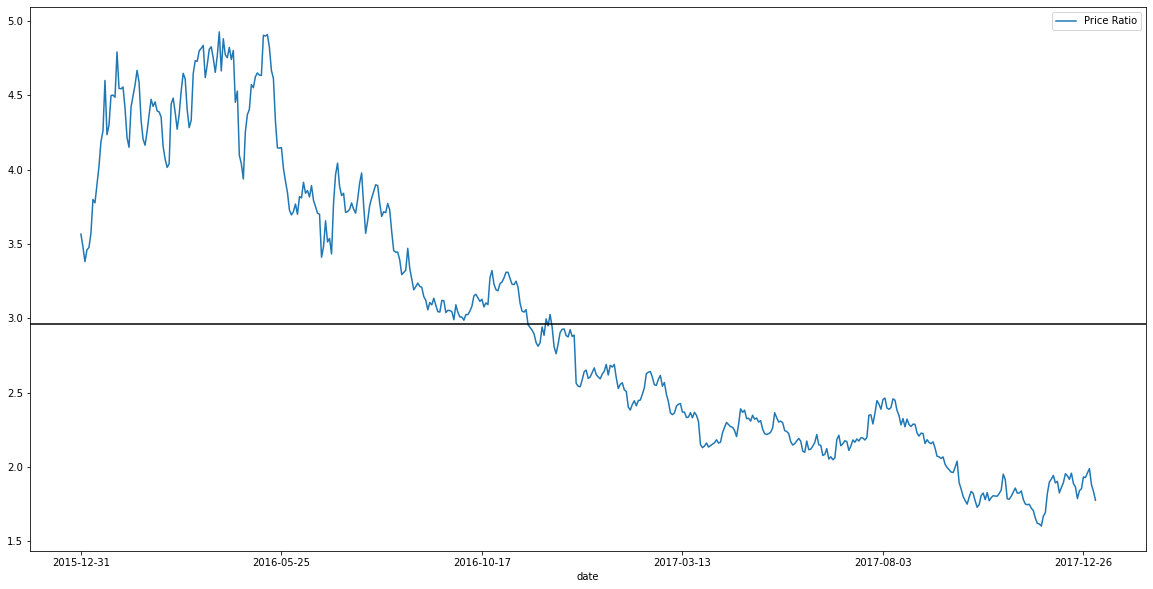

In [ ]:
# calculate price ratio
price_ratio = train['stock1']/train['stock2']
price_ratio.plot(figsize=(20,10))
plt.axhline(price_ratio.mean(), color='black')
plt.legend(['Price Ratio'])

To make the price ratio more useful in statistical terms, we convert it to a z-score. We calculate z-score as:


```
Z Score(Value) = (Value — Mean) / Standard Deviation
```

Doing so assumes that the underlying distribution of ratios is normal.


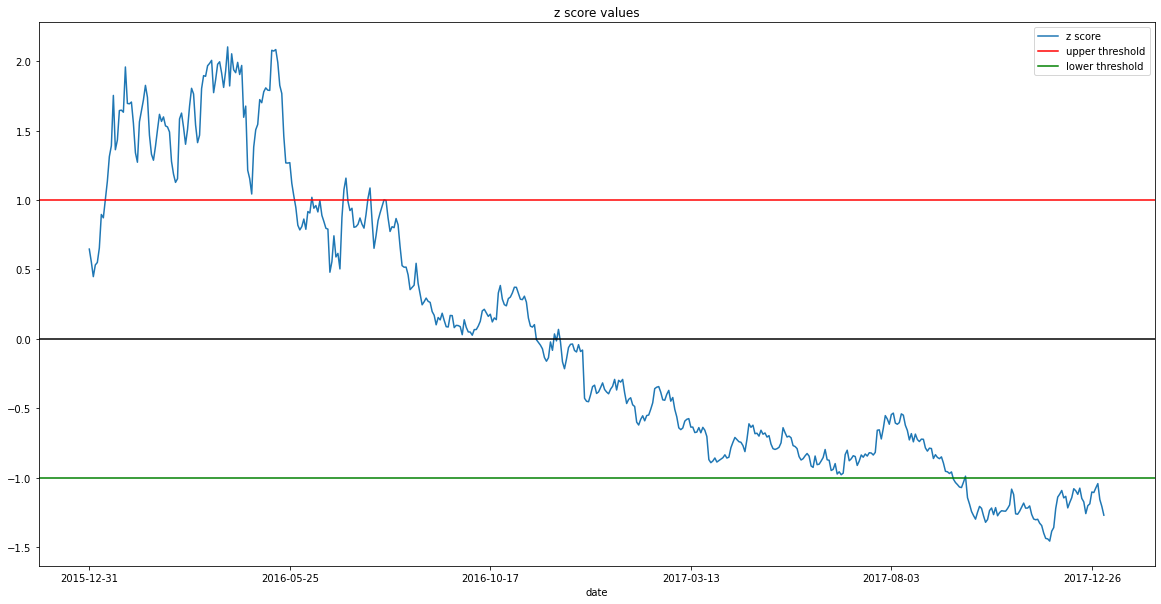

In [ ]:
# calculate the zscore
zscore = (price_ratio - np.mean(price_ratio)) / np.std(price_ratio)

zscore.plot(figsize=(20,10), label='z score')
plt.axhline(zscore.mean(), color="black")
plt.axhline(1.0, color='red', label="upper threshold")
plt.axhline(-1.0, color='green', label="lower threshold")
plt.title("z score values")
plt.legend()
plt.show()

# Developing a trading signal (logic)

Continuing on to our next steps of developing our strategy:
2. Create features from data to identify a trading signal/logic
3. Features can be moving averages or ratios of price data, correlations or more complex signals — combine these to create new features
4. Generate a trading signal using these features, i.e which instruments are a buy, a sell or neutral


# Feature Engineering

We want to predict the direction of ratio move. Since our pair is cointegrated, the price ratio of our selected stocks move around and back to the mean. We will look at measure related to the mean of the ratio and divergence of the current value from the mean. 

In [ ]:
# feature engineering

# gridsearchCv 

# 5 day moving average of price ratio
price_ratios_mavg5 = price_ratio.rolling(window=5, center=False).mean()

# 30 day moving average of price ratio
price_ratios_mavg30 = price_ratio.rolling(window=30, center=False).mean()

# 30 day standard deviation, i.e., volatility in price ratio
std_30 = price_ratio.rolling(window=30, center=False).std()

# z score using 5 day moving avg and 60 day moving avg
zscore_30_5 = (price_ratios_mavg5 - price_ratios_mavg30)/std_30


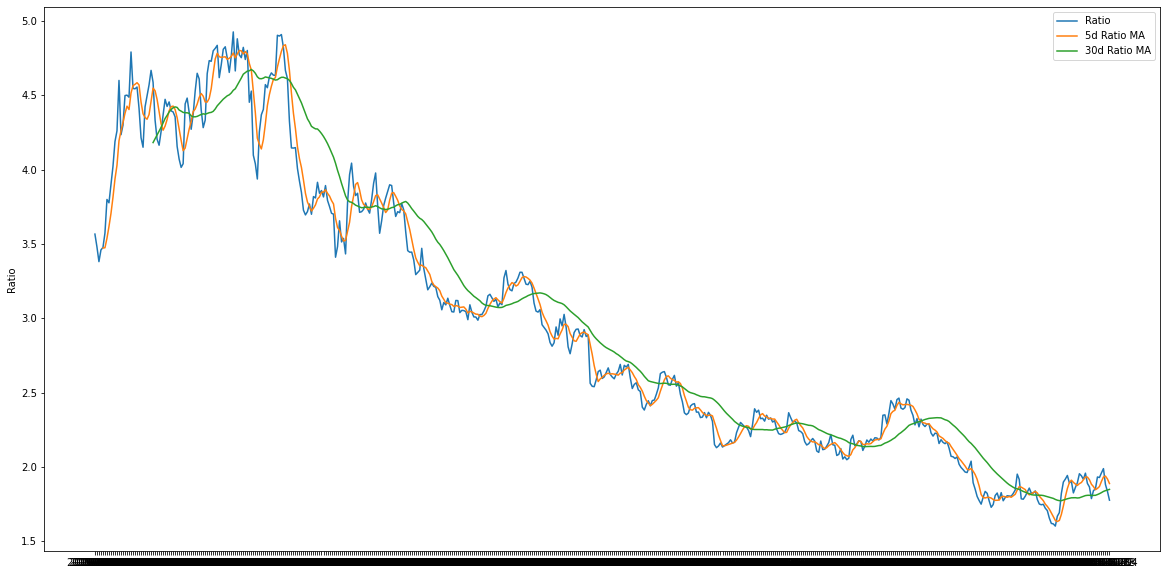

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(price_ratio.index, price_ratio.values)
plt.plot(price_ratios_mavg5.index, price_ratios_mavg5.values)
plt.plot(price_ratios_mavg30.index, price_ratios_mavg30.values)
plt.legend(['Ratio', '5d Ratio MA', '30d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

# plot prices

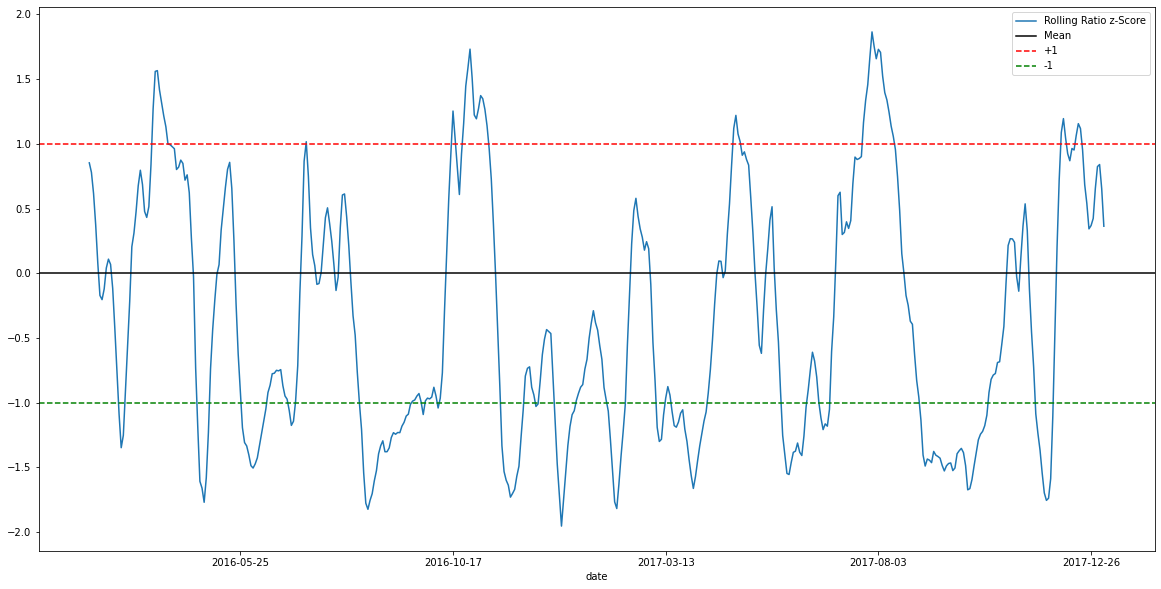

In [ ]:
plt.figure(figsize=(20,10))
zscore_30_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

# Testing model on real data

 Finally, we want to see how profitable our trading signal is.

In [ ]:
# create a dataframe for trading signals
signals = pd.DataFrame()

signals['stock1'] = train['stock1'] 
signals['stock2'] = train['stock2'] 

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore_30_5 ########## use zscore non-rolling maybe
signals['z upper limit'] = np.mean(signals['z']) + 1.5 * np.std(signals['z']) ###### 1.5x
signals['z lower limit'] = np.mean(signals['z']) - 1.5 * np.std(signals['z']) ###### 1.5x

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
signals['signals2'] = -signals['signals1']

# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['positions2'] = signals['signals2'].diff()

signals[30:]

,stock1,stock2,z,z upper limit,z lower limit,signals1,signals2,positions1,positions2
date,,,,,,,,,
2016-02-16,46.848087,10.810000,0.780084,1.083132,-1.792147,0,0,0.0,0.0
2016-02-17,48.067665,11.430000,0.616489,1.083132,-1.792147,0,0,0.0,0.0
2016-02-18,47.856754,11.490000,0.374374,1.083132,-1.792147,0,0,0.0,0.0
2016-02-19,47.517471,11.160000,0.076640,1.083132,-1.792147,0,0,0.0,0.0
2016-02-22,48.278557,11.050000,-0.171302,1.083132,-1.792147,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2017-12-28,81.974380,41.810001,0.655150,1.083132,-1.792147,0,0,0.0,0.0
2017-12-29,81.802261,41.119999,0.824604,1.083132,-1.792147,0,0,0.0,0.0
2018-01-02,82.194328,43.669998,0.840347,1.083132,-1.792147,0,0,0.0,0.0


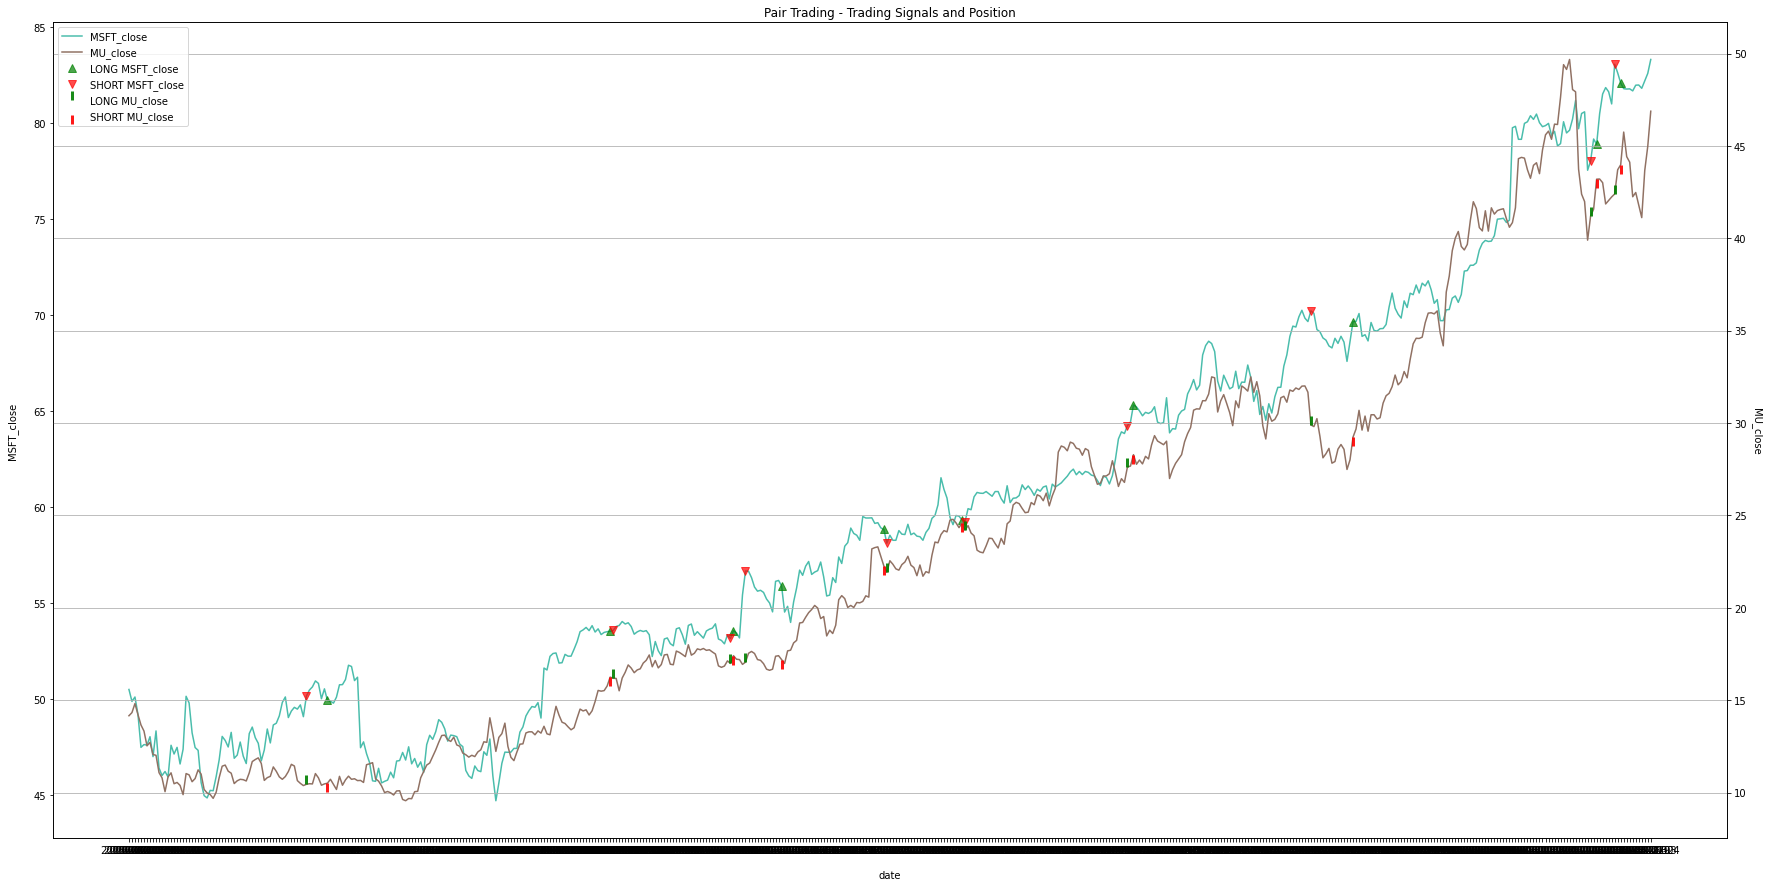

In [ ]:
# visualize trading signals and position
fig=plt.figure(figsize=(30,15))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['stock1'], c='#4abdac')
l2, = bx2.plot(signals['stock2'], c='#907163')

u1, = bx.plot(signals['stock1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['stock1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['stock2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['stock2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(stock1,)
bx2.set_ylabel(stock2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [stock1, stock2,'LONG {}'.format(stock1),'SHORT {}'.format(stock1),'LONG {}'.format(stock2),'SHORT {}'.format(stock2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
#plt.xticks(['2016', '2017'])
plt.grid(True)

In [ ]:
# initial capital to calculate the actual pnl
initial_capital = 500000

# shares to buy for each position
positions1 = initial_capital// max(signals['stock1'])
positions2 = initial_capital// max(signals['stock2'])

In [ ]:
# calculate PnL

# PnL ticker 1
portfolio = pd.DataFrame()
portfolio['date'] = signals.index.tolist()
portfolio = portfolio.set_index('date')

portfolio['stock1'] = signals['stock1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['stock1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['stock1'] * positions1).cumsum()
portfolio['total_stock1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total_stock1'].pct_change()
portfolio['positions1'] = signals['positions1']

# PnL ticker 2
portfolio['stock2'] = signals['stock2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['stock2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['stock2'] * positions2).cumsum()
portfolio['total_stock2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total_stock2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total PnL and z score
portfolio['z'] = signals['z']
portfolio['total_asset'] = portfolio['total_stock1'] + portfolio['total_stock2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']

#portfolio = portfolio.dropna()

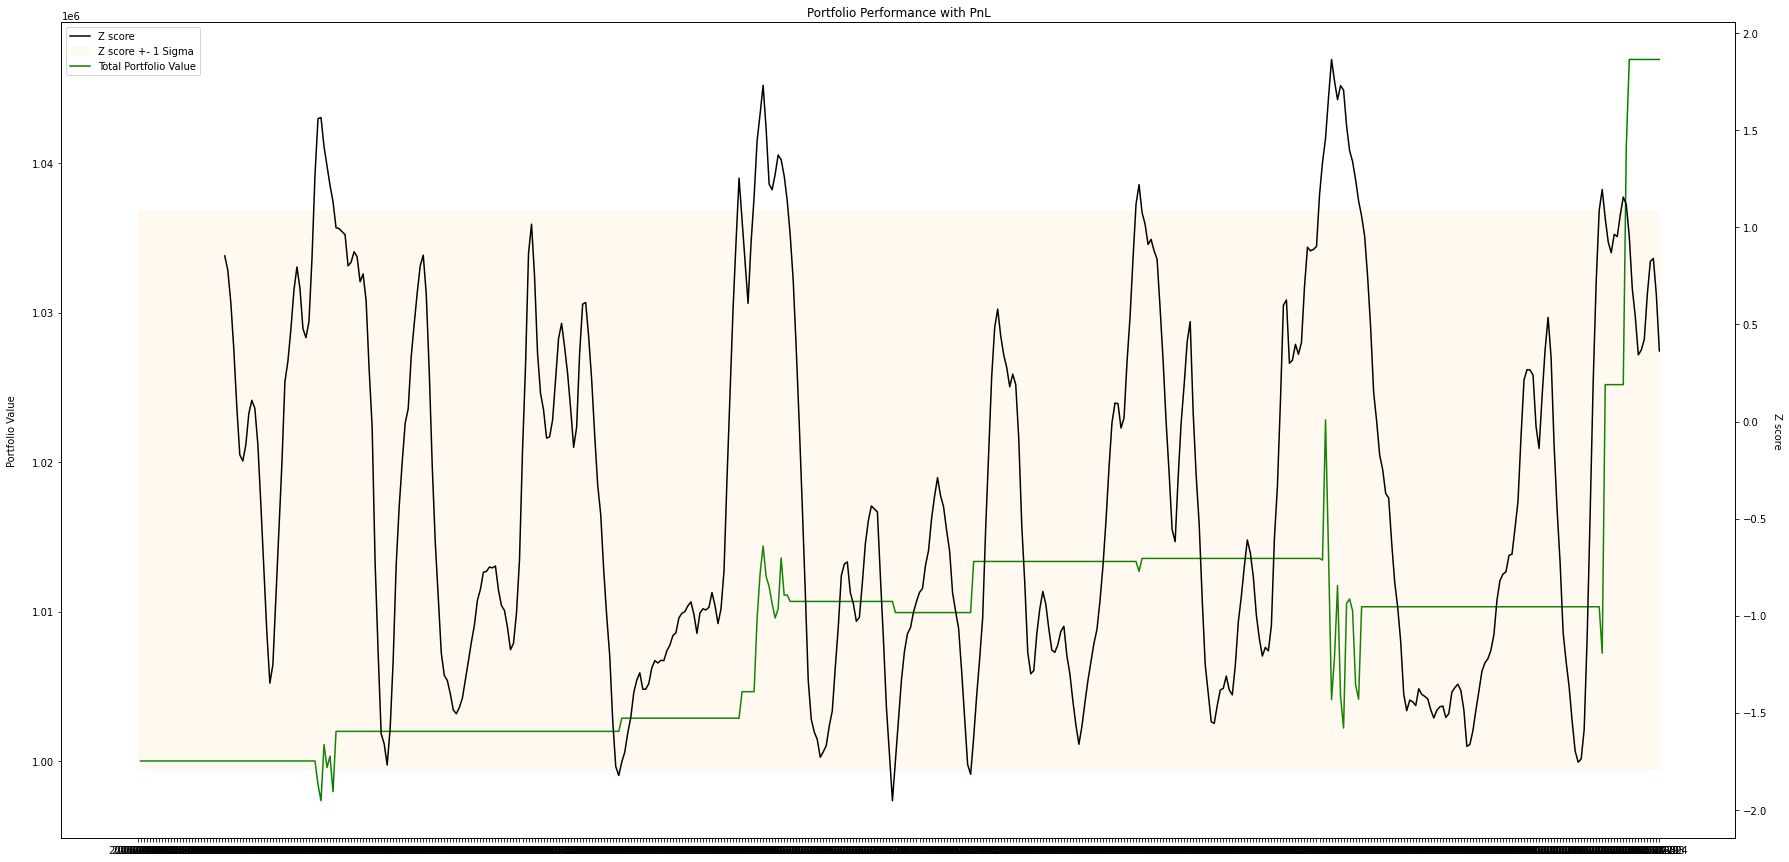

In [ ]:
# plot the asset value change of the portfolio and pnl along with z-score

fig = plt.figure(figsize=(30,15),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total_asset'], c='green')
l2, = ax2.plot(portfolio['z'], c='black')

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'], portfolio['z lower limit'], alpha=0.075,color='#ffb93f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z score',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with PnL')
plt.legend([l2,b,l1],['Z score','Z score +- 1 Sigma','Total Portfolio Value'],loc='upper left')
plt.show()

One measurement of how well our portfolio using our trading signal performs is the Compound Annual Growth Rate (CAGR). 

In [ ]:
# calculate CAGR
final_portfolio = portfolio['total_asset'].iloc[-1]

start_date = datetime.strptime(portfolio.index[0], '%Y-%m-%d')
end_date = datetime.strptime(portfolio.index[-1], '%Y-%m-%d')
delta = (end_date - start_date)

#delta
returns = (final_portfolio/initial_capital) ** (365/735) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 44.339%


In [ ]:
# Need to create introduction to pair trading, introduce research question, 
# statistical arbitrage, tech sector intro, analysis, etc

# Next Steps:
#     use linear regression to find hedge ratio, adf score, residual
#     calculate spread
#         plot spread
#     create strategy 
#         entry and exit points
#         generate trading signals
#         visualize z score thresholds
#     backtest using dataframe
#         visualize trading signals and positions
#         determine PnL metrics
#         calculate PnL
#             visualize
#         plot PnL / change in portfolio value
#             visualize
#         calculate CAGR
#         calculate Sharpe ratio
#     Parameter tuning
#         entry exit points
#             visualize
#         max holding period
#     Test on test_data using parameters optimized for training set
#         visualize
#         calculate PnL metrics
#             visualize
#     compare to benchmark
#         visualize performance
#     Determine profitability, feasof strategy + analysis
#         analysis about implementing in live trading mode


#     Implement Live Paper Trading
#.        Interactive brokers trader workstation
